In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np


In [2]:
gdf_model = gpd.read_file(
    r"../../Data/Processed/PT-FireSprd_v3.0/L2_FireBehavior/PT-FireSprd_v3.0_L2_model.shp"
)

gdf_log = gpd.read_file(
    r"../../Data/Processed/PT-FireSprd_v3.0/L2_FireBehavior/PT-FireSprd_v3.0_L2_model_log.shp"
)

df_model = pd.DataFrame(gdf_model.drop(columns="geometry"))
df_log = pd.DataFrame(gdf_log.drop(columns="geometry"))

print("Shapefiles carregados com sucesso:")
print(f"df_model: {df_model.shape}, df_log: {df_log.shape}")


Shapefiles carregados com sucesso:
df_model: (851, 109), df_log: (851, 109)


In [3]:
ros_col = "ros_p"
correlations_data = {}

vars_model = [c for c in df_model.columns if c != ros_col]
vars_log = [c for c in df_log.columns if c != ros_col]

common_vars = list(set(vars_model).intersection(set(vars_log)))

print(f"Variáveis em comum: {len(common_vars)}")


Variáveis em comum: 108


In [4]:
for var in common_vars:

    if var not in correlations_data:
        correlations_data[var] = {"variable": var}

    # Linear: ROS vs X
    correlations_data[var]["corr_ros_p_model"] = (
        df_model[[ros_col, var]].dropna().corr().iloc[0, 1]
    )

    # Exponencial: log(ROS) vs X
    correlations_data[var]["corr_log_ros_p_model"] = (
        df_log[[ros_col]].join(df_model[var]).dropna().corr().iloc[0, 1]
    )

    # Logarítmica: ROS vs log(X)
    correlations_data[var]["corr_ros_p_model_log"] = (
        df_model[[ros_col]].join(df_log[var]).dropna().corr().iloc[0, 1]
    )

    # Potência: log(ROS) vs log(X)
    correlations_data[var]["corr_log_ros_p_model_log"] = (
        df_log[[ros_col, var]].dropna().corr().iloc[0, 1]
    )

print("Correlação calculada para todas as variáveis comuns.")


Correlação calculada para todas as variáveis comuns.


In [5]:
correlations_df = pd.DataFrame(correlations_data.values())

desired_columns = [
    "variable",
    "corr_ros_p_model",
    "corr_log_ros_p_model",
    "corr_ros_p_model_log",
    "corr_log_ros_p_model_log"
]

for col in desired_columns:
    if col not in correlations_df.columns:
        correlations_df[col] = np.nan

correlations_df = correlations_df[desired_columns]

print("DataFrame consolidado criado.")
correlations_df.head(5)


DataFrame consolidado criado.


,variable,corr_ros_p_model,corr_log_ros_p_model,corr_ros_p_model_log,corr_log_ros_p_model_log
0,wco_300_av,-0.053243,-0.048581,-0.054349,-0.048787
1,LowCC_p_av,-0.113924,-0.162713,-0.132107,-0.189867
2,sP_hPa_av,0.072333,0.074625,0.072276,0.074788
3,wsi_850_av,-0.088897,-0.122705,-0.092644,-0.123501
4,sW_100_av,-0.083819,-0.119491,-0.081622,-0.116670


In [6]:
correlations_df["Relation"] = ""

for idx, row in correlations_df.iterrows():

    corr_values = {}

    if not pd.isna(row["corr_ros_p_model"]):
        corr_values["L ROS - L var"] = abs(row["corr_ros_p_model"])

    if not pd.isna(row["corr_log_ros_p_model"]):
        corr_values["Log ROS - L var"] = abs(row["corr_log_ros_p_model"])

    if not pd.isna(row["corr_ros_p_model_log"]):
        corr_values["L ROS - Log var"] = abs(row["corr_ros_p_model_log"])

    if not pd.isna(row["corr_log_ros_p_model_log"]):
        corr_values["Log ROS - Log var"] = abs(row["corr_log_ros_p_model_log"])

    if corr_values:
        max_corr_type = max(corr_values, key=corr_values.get)

        if max_corr_type == "L ROS - L var":
            correlations_df.at[idx, "Relation"] = "Relação Linear"
        elif max_corr_type == "Log ROS - L var":
            correlations_df.at[idx, "Relation"] = "Relação Exponencial"
        elif max_corr_type == "L ROS - Log var":
            correlations_df.at[idx, "Relation"] = "Relação Logarítmica"
        elif max_corr_type == "Log ROS - Log var":
            correlations_df.at[idx, "Relation"] = "Relação Potência"
    else:
        correlations_df.at[idx, "Relation"] = "Sem dados suficientes"

print("Tipo de relação determinado para todas as variáveis.")
correlations_df.head(5)


Tipo de relação determinado para todas as variáveis.


,variable,corr_ros_p_model,corr_log_ros_p_model,corr_ros_p_model_log,corr_log_ros_p_model_log,Relation
0,wco_300_av,-0.053243,-0.048581,-0.054349,-0.048787,Relação Logarítmica
1,LowCC_p_av,-0.113924,-0.162713,-0.132107,-0.189867,Relação Potência
2,sP_hPa_av,0.072333,0.074625,0.072276,0.074788,Relação Potência
3,wsi_850_av,-0.088897,-0.122705,-0.092644,-0.123501,Relação Potência
4,sW_100_av,-0.083819,-0.119491,-0.081622,-0.116670,Relação Exponencial


In [7]:
output_file = "../../Data/Data_Exploration/ROS_var_correlations.csv"
correlations_df.to_csv(output_file, index=False)

print(f"Successfully created {output_file}")
print(f"Total variables: {len(correlations_df)}")

print("\n=== DISTRIBUIÇÃO DAS RELAÇÕES ===")
relation_counts = correlations_df["Relation"].value_counts()
for relation_type, count in relation_counts.items():
    print(f"{relation_type}: {count} variáveis ({count/len(correlations_df)*100:.1f}%)")

print("\nPrimeiras 10 linhas do DataFrame:")
print(correlations_df.head(10))


Successfully created ../../Data/Data_Exploration/ROS_var_correlations.csv
Total variables: 108

=== DISTRIBUIÇÃO DAS RELAÇÕES ===
Relação Potência: 40 variáveis (37.0%)
Relação Exponencial: 28 variáveis (25.9%)
Relação Linear: 20 variáveis (18.5%)
Relação Logarítmica: 18 variáveis (16.7%)
Sem dados suficientes: 2 variáveis (1.9%)

Primeiras 10 linhas do DataFrame:
     variable  corr_ros_p_model  corr_log_ros_p_model  corr_ros_p_model_log  \
0  wco_300_av         -0.053243             -0.048581             -0.054349   
1  LowCC_p_av         -0.113924             -0.162713             -0.132107   
2   sP_hPa_av          0.072333              0.074625              0.072276   
3  wsi_850_av         -0.088897             -0.122705             -0.092644   
4   sW_100_av         -0.083819             -0.119491             -0.081622   
5   d_2m_C_av         -0.163665             -0.193077             -0.139853   
6    BLH_m_rt          0.048922              0.089083             -0.013431   
7

In [8]:
# =========================
# Top 20 variáveis por |corr|
# =========================

correlations_df["max_abs_corr"] = correlations_df[
    [
        "corr_ros_p_model",
        "corr_log_ros_p_model",
        "corr_ros_p_model_log",
        "corr_log_ros_p_model_log"
    ]
].abs().max(axis=1)

top20 = correlations_df.sort_values(
    by="max_abs_corr",
    ascending=False
).head(50)

print("\n=== TOP 20 VARIÁVEIS COM MAIOR |CORRELAÇÃO| ===")
print(
    top20[
        [
            "variable",
            "max_abs_corr",
            "Relation",
            "corr_ros_p_model",
            "corr_log_ros_p_model",
            "corr_ros_p_model_log",
            "corr_log_ros_p_model_log"
        ]
    ].to_string(index=False)
)



=== TOP 20 VARIÁVEIS COM MAIOR |CORRELAÇÃO| ===
  variable  max_abs_corr            Relation  corr_ros_p_model  corr_log_ros_p_model  corr_ros_p_model_log  corr_log_ros_p_model_log
duration_p      0.531969    Relação Potência         -0.409966             -0.521266             -0.447093                 -0.531969
 ros_p_lg1      0.512388      Relação Linear          0.512388              0.460040              0.448108                  0.486556
    HDW_av      0.437537 Relação Exponencial          0.350603              0.437537              0.280410                  0.398980
   dfmc_av      0.371073    Relação Potência         -0.247936             -0.365438             -0.259485                 -0.371073
  rh_2m_av      0.358410 Relação Exponencial         -0.246232             -0.358410             -0.255705                 -0.353775
 VPD_Pa_av      0.343305 Relação Exponencial          0.242571              0.343305              0.212068                  0.325783
wv10_kh_av      0.33

In [9]:
# Parâmetros
top_n = 15

# Para cada coluna de correlação
for col in ['corr_ros_p_model', 'corr_log_ros_p_model', 'corr_ros_p_model_log', 'corr_log_ros_p_model_log']:
    if col in correlations_df.columns:
        # Remover NaN e ordenar por valor absoluto
        df_filtrado = correlations_df.dropna(subset=[col])
        top_vars = df_filtrado.reindex(df_filtrado[col].abs().sort_values(ascending=False).index).head(top_n)
        
        print(f"\nTop {top_n} |{col}|:")
        print(top_vars[['variable', col]])


Top 15 |corr_ros_p_model|:
       variable  corr_ros_p_model
13    ros_p_lg1          0.512388
18   duration_p         -0.409966
97       HDW_av          0.350603
91      dfmc_av         -0.247936
104    rh_2m_av         -0.246232
95    VPD_Pa_av          0.242571
68   wv100_k_av          0.238788
29     BLH_m_av          0.232759
15   wv10_kh_av          0.232392
63   LCL_hPa_av         -0.217367
27       Recirc         -0.201922
19    wv_950_av          0.199278
67    t_2m_C_av          0.193374
36      CircVar         -0.181349
48   FWI_12h_av          0.179750

Top 15 |corr_log_ros_p_model|:
       variable  corr_log_ros_p_model
18   duration_p             -0.521266
13    ros_p_lg1              0.460040
97       HDW_av              0.437537
91      dfmc_av             -0.365438
104    rh_2m_av             -0.358410
95    VPD_Pa_av              0.343305
29     BLH_m_av              0.328066
27       Recirc             -0.316887
63   LCL_hPa_av             -0.313754
67    t_2m_C_av 

In [10]:
# =========================
# Compute strongest correlation per variable
# =========================
corr_cols = [
    "corr_ros_p_model",
    "corr_log_ros_p_model",
    "corr_ros_p_model_log",
    "corr_log_ros_p_model_log"
]

def get_max_corr(row):
    vals = row[corr_cols].dropna()
    if vals.empty:
        return pd.Series([np.nan, np.nan])
    max_val = vals.loc[vals.abs().idxmax()]
    return pd.Series([max_val, abs(max_val)])

correlations_df[["max_corr", "max_abs_corr"]] = correlations_df.apply(
    get_max_corr, axis=1
)

# =========================
# Filter for plotting
# =========================
plot_df = correlations_df[correlations_df["max_abs_corr"] > 0.25].copy()
plot_df = plot_df.sort_values("max_abs_corr", ascending=False)

plot_df = plot_df.loc[~plot_df['variable'].isin(['inidoy', 'enddoy'])]


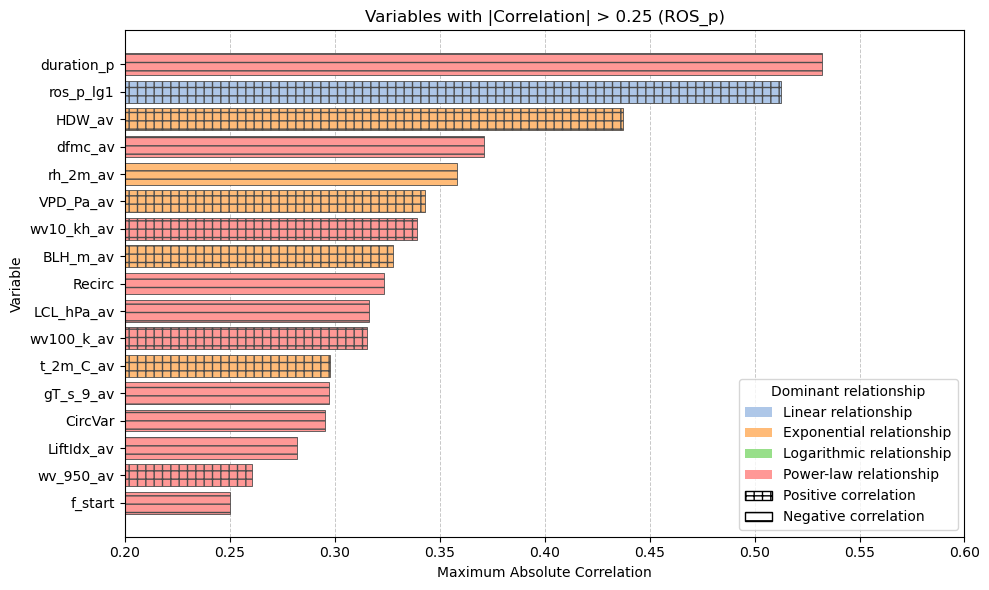

In [11]:
# =========================
# Bar plot of strongest correlations (refined style)
# =========================
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ---- Pastel color palette by relationship type ----
relation_colors = {
    "Relação Linear": "#AEC7E8",        # pastel blue
    "Relação Exponencial": "#FFBB78",   # pastel orange
    "Relação Logarítmica": "#98DF8A",   # pastel green
    "Relação Potência": "#FF9896"       # pastel red
}

plot_df["color"] = plot_df["Relation"].map(relation_colors)

# ---- Hatch mapping (lighter texture) ----
plot_df["hatch"] = plot_df["max_corr"].apply(lambda x: "+" if x > 0 else "-")

# =========================
# Plot
# =========================
fig, ax = plt.subplots(figsize=(10, max(6, 0.35 * len(plot_df))))

bars = ax.barh(
    plot_df["variable"],
    plot_df["max_abs_corr"],
    color=plot_df["color"],
    edgecolor="0.3",
    linewidth=0.6
)

# Apply lighter hatches
for bar, hatch in zip(bars, plot_df["hatch"]):
    bar.set_hatch(hatch * 2)

# ---- Gridlines ----
ax.grid(
    axis="x",
    linestyle="--",
    linewidth=0.7,
    alpha=0.7
)
ax.set_axisbelow(True)

# ---- Labels & title ----
ax.set_xlabel("Maximum Absolute Correlation")
ax.set_ylabel("Variable")
ax.set_title("Variables with |Correlation| > 0.25 (ROS_p)")
ax.set_xlim(0.2, 0.6)

ax.invert_yaxis()

# ---- Legend (English) ----
legend_elements = [
    Patch(facecolor=relation_colors["Relação Linear"], label="Linear relationship"),
    Patch(facecolor=relation_colors["Relação Exponencial"], label="Exponential relationship"),
    Patch(facecolor=relation_colors["Relação Logarítmica"], label="Logarithmic relationship"),
    Patch(facecolor=relation_colors["Relação Potência"], label="Power-law relationship"),
    Patch(facecolor="white", edgecolor="black", hatch="++", label="Positive correlation"),
    Patch(facecolor="white", edgecolor="black", hatch="--", label="Negative correlation"),
]

ax.legend(
    handles=legend_elements,
    title="Dominant relationship",
    loc="lower right",
    frameon=True
)

plt.tight_layout()
plt.show()
